<a href="https://colab.research.google.com/github/JuliethLopez/chatbot_simpsons/blob/master/Generador%20de%20texto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generador de texto de los Simpsons

Con éste código se pretende generar texto con un red neuronal recurrente, particularmente una red GRU. El modelo debe aprender a generar caracteres para formar palabras con sentido y con ello una oración que corresponda a una palabra o una frase.

Para comenzar cargaremos las librerias y la base de datos:

In [1]:
#librerias
import tensorflow as tf #para el uso de keras y el manejo de tensores.
import numpy as np #para manejo de bases de datos
import os #para leer y escribir archivos
import time
from tensorflow.keras.utils import to_categorical, plot_model

print("Versión de Tensorflow: ", tf.__version__)

Versión de Tensorflow:  2.2.0


La base de datos fue tomada del conjunto de bases de datos __The Simpsons by the Data__ en [data.world](https://data.world/data-society/the-simpsons-by-the-data) (*para usar esta página es necesario registrarse*). Éste contiene distintas bases de datos que con los personajes, las locaciones, los detalles de los episodios, y los dialogos de aproximadamente 600 episodios de los simpsons. Utilizamos la base de datos *simpsons_script_lines.csv* que inicialmente tenia 158271 lineas de conversación, por ejemplo "Lisa Simpson: Challenge accepted!" y la filtramos por la variable raw_text=TRUE usando SQL desde la misma página [data.world](https://data.world/data-society/the-simpsons-by-the-data), obteniendo 132113 lineas.

    SELECT raw_text
    FROM simpsons_script_lines
    WHERE speaking_line = 'Guess what. I also play Frankenstein!' OR speaking_line = TRUE
    
Descargamos el archivo en formato XLSX y lo transformamos a formato TXT, no descargamos los datos en formato CSV porque aparecián caracteres no imprimibles (¦ â € Ã ©).

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
#datos
text = open('/content/drive/My Drive/Colab Notebooks/simpsons_script_lines.txt', 'rb').read().decode(encoding='utf-8')

In [6]:
#primeros 200 caracteres
print(text[:250])

Miss Hoover: No, actually, it was a little of both. Sometimes when a disease is in all the magazines and all the news shows, it's only natural that you think you have it.
Lisa Simpson: (NEAR TEARS) Where's Mr. Bergstrom?
Miss Hoover: I don't know. Al


Contamos el numero de caracteres porque el modelo se entrenara desde los caracteres, no desde las palabras como veremos más adelante.

In [8]:
print ('Length of text: {} characters'.format(len(text)))

Length of text: 9781832 characters


## 1. Vocabulario o alfabeto

Si bien los datos están en inglés, hay algunas palabras en otros idiomas debido a la complejitud de los personajes de la serie, por eso hemos decidido dejar los carácteres que pertenecen a esos otro idiomas.

In [9]:
vocab = sorted(set(text)) #set extrae caracteres distintos, sorted los ordena
print ('{} carácteres únicos'.format(len(vocab)))

137 carácteres únicos


Dentro de los caracteres tenemos \n que se utiliza como indicador para el salto de linea y \r que se utiliza para regresar del final de la linea al inicio de la linea. Pero por otro lado tenemos un caracter no deseable \xad que vamos a eliminar.

In [10]:
text = text.replace('\N{SOFT HYPHEN}', '') #elimina \xad y eliminaria mas caracteres suaves si hubieran.

In [11]:
vocab = sorted(set(text)) #set extrae caracteres distintos, sorted los ordena
print ('{} carácteres únicos'.format(len(vocab)))

136 carácteres únicos


## 2. Diccionarios de ida y vuelta
Ahora que tenemos el vocabulario de caracteres podemos crear los diccionarios de ida y vuelta que lo que harán es darle un id a cada caracter ya que para la maquina es más facil trabajar con números, de modo que cuando una frase entra, se traduce a numeros cada uno de los caracteres y se predicen los id, que luego seran transformados a carácteres para poder leerlos.

In [12]:
charxid = {u:i for i, u in enumerate(vocab)} #le damos un indice a cada caractér
text_as_int = np.array([charxid[i] for i in text]) #caracteres a números

In [13]:
#id de los primeros 10 caracteres
for char,_ in zip(charxid, range(10)):
    print('{:4s}: {:3d},'.format(repr(char), charxid[char])) #s: str, d: int

'\n':   0,
' ' :   1,
'!' :   2,
'#' :   3,
'$' :   4,
'%' :   5,
'&' :   6,
"'" :   7,
'(' :   8,
')' :   9,


In [14]:
#primeros 15 carácteres del texto a enteros
print ('{} ---- carácteres a enteros ---- > {}'.format(repr(text[:15]), text_as_int[:15]))

'Miss Hoover: No' ---- carácteres a enteros ---- > [41 68 78 78  1 36 74 74 81 64 77 26  1 42 74]


In [15]:
idxchar = np.array(vocab) #números a caracteres
print("\nidxchar:", idxchar)


idxchar: ['\n' ' ' '!' '#' '$' '%' '&' "'" '(' ')' '*' '+' ',' '-' '.' '/' '0' '1'
 '2' '3' '4' '5' '6' '7' '8' '9' ':' ';' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G'
 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y'
 'Z' '[' '\\' ']' '_' '`' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l'
 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' '¡' '¿' 'À' 'Ä'
 'È' 'É' 'Ñ' 'Ö' 'Ù' 'Ü' 'à' 'á' 'â' 'ã' 'ä' 'å' 'æ' 'ç' 'è' 'é' 'ê' 'ë'
 'ì' 'í' 'ï' 'ñ' 'ò' 'ó' 'ô' 'õ' 'ö' 'ø' 'ù' 'ú' 'û' 'ü' 'ā' 'Ĉ' 'ē' 'ě'
 'Ĝ' 'ī' 'Ĭ' 'ł' 'ń' 'ŭ' 'ż' 'ǎ' 'ǐ' 'ǒ']


## 3. Datos de entrenamiento y etiquetas

Los datos que tenemos aún no están listos para usarse en el modelo, pues no están etiquetados. Para entender como etiquetar los datos usemos esta frase como ejemplo "Miss Hoover: No, actually, it was a little of both.". El modelo que vamos a utilizar necesita una frase de entrada, tomemos "Miss Hoover: No, actually, it was a littl" y necesita una etiqueta, en este caso es "iss Hoover: No, actually, it was a little", así:


|                     Entrada                 |  Etiqueta   |
|---------------------------------------------|:---:|
| "Miss Hoover: No, actually, it was a littl" | "iss Hoover: No, actually, it was a little" |
| "iss Hoover: No, actually, it was a little" | "ss Hoover: No, actually, it was a little " |
| "ss Hoover: No, actually, it was a little " | "s Hoover: No, actually, it was a little o" |
| "s Hoover: No, actually, it was a little o" | " Hoover: No, actually, it was a little of" |

Entonces, empezaremos por definir el tamañao de las entradas y las etiquetas.

In [16]:
seq_length = 100 #máxima longitud de la frase
#examples_per_epoch = len(text)//(seq_length+1)
examples_per_epoch = len(text)-seq_length #numero de datos por epoca
examples_per_epoch

9781721

Los datos necesitan ser transformados a tensores para que puedan ser utilizados en el modelo, los transformaremos con *tf.data.Dataset.from_tensor_slices*.

In [17]:
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) #se tranforma de numpy a tf
print("Tensor:", char_dataset)

#ejemplo
for i in char_dataset.take(11):
  print(idxchar[i.numpy()])

Tensor: <TensorSliceDataset shapes: (), types: tf.int64>
M
i
s
s
 
H
o
o
v
e
r


Ahora podemos construir las secuencias de entrenamiento, tengamos en cuenta que las estas se componen por seq_length caracteres mas un caracter que es el que se usara para crear la etiqueta.

In [18]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)
print("sequences:", sequences)

for item in sequences.take(2):
  print(repr(idxchar[item.numpy()])) #rep vuelve imprimible lo que es imprimible

sequences: <BatchDataset shapes: (101,), types: tf.int64>
array(['M', 'i', 's', 's', ' ', 'H', 'o', 'o', 'v', 'e', 'r', ':', ' ',
       'N', 'o', ',', ' ', 'a', 'c', 't', 'u', 'a', 'l', 'l', 'y', ',',
       ' ', 'i', 't', ' ', 'w', 'a', 's', ' ', 'a', ' ', 'l', 'i', 't',
       't', 'l', 'e', ' ', 'o', 'f', ' ', 'b', 'o', 't', 'h', '.', ' ',
       'S', 'o', 'm', 'e', 't', 'i', 'm', 'e', 's', ' ', 'w', 'h', 'e',
       'n', ' ', 'a', ' ', 'd', 'i', 's', 'e', 'a', 's', 'e', ' ', 'i',
       's', ' ', 'i', 'n', ' ', 'a', 'l', 'l', ' ', 't', 'h', 'e', ' ',
       'm', 'a', 'g', 'a', 'z', 'i', 'n', 'e', 's', ' '], dtype='<U1')
array(['a', 'n', 'd', ' ', 'a', 'l', 'l', ' ', 't', 'h', 'e', ' ', 'n',
       'e', 'w', 's', ' ', 's', 'h', 'o', 'w', 's', ',', ' ', 'i', 't',
       "'", 's', ' ', 'o', 'n', 'l', 'y', ' ', 'n', 'a', 't', 'u', 'r',
       'a', 'l', ' ', 't', 'h', 'a', 't', ' ', 'y', 'o', 'u', ' ', 't',
       'h', 'i', 'n', 'k', ' ', 'y', 'o', 'u', ' ', 'h', 'a', 'v', 'e',
       

Juntemos los caracteres para que sean mas facil de visualizar.

In [19]:
for item in sequences.take(2):
  print(repr(''.join(idxchar[item.numpy()])))

'Miss Hoover: No, actually, it was a little of both. Sometimes when a disease is in all the magazines '
"and all the news shows, it's only natural that you think you have it.\nLisa Simpson: (NEAR TEARS) Wher"


Aquí dividiremos las secuencias en entradas y etiquetas con la misma longitud. El método *.map* nos permite aplicar una función simple a cada lote, similar a la función apply de R, se busca duplicar cada secuencia y cambiarla para formar el texto de entrada y de salida.

In [20]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)
dataset

<MapDataset shapes: ((100,), (100,)), types: (tf.int64, tf.int64)>

In [21]:
for item in dataset.take(1):
  print(item)

(<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([41, 68, 78, 78,  1, 36, 74, 74, 81, 64, 77, 26,  1, 42, 74, 12,  1,
       60, 62, 79, 80, 60, 71, 71, 84, 12,  1, 68, 79,  1, 82, 60, 78,  1,
       60,  1, 71, 68, 79, 79, 71, 64,  1, 74, 65,  1, 61, 74, 79, 67, 14,
        1, 47, 74, 72, 64, 79, 68, 72, 64, 78,  1, 82, 67, 64, 73,  1, 60,
        1, 63, 68, 78, 64, 60, 78, 64,  1, 68, 78,  1, 68, 73,  1, 60, 71,
       71,  1, 79, 67, 64,  1, 72, 60, 66, 60, 85, 68, 73, 64, 78])>, <tf.Tensor: shape=(100,), dtype=int64, numpy=
array([68, 78, 78,  1, 36, 74, 74, 81, 64, 77, 26,  1, 42, 74, 12,  1, 60,
       62, 79, 80, 60, 71, 71, 84, 12,  1, 68, 79,  1, 82, 60, 78,  1, 60,
        1, 71, 68, 79, 79, 71, 64,  1, 74, 65,  1, 61, 74, 79, 67, 14,  1,
       47, 74, 72, 64, 79, 68, 72, 64, 78,  1, 82, 67, 64, 73,  1, 60,  1,
       63, 68, 78, 64, 60, 78, 64,  1, 68, 78,  1, 68, 73,  1, 60, 71, 71,
        1, 79, 67, 64,  1, 72, 60, 66, 60, 85, 68, 73, 64, 78,  1])>)


Juntemos los caracteres para que sean mas facil de visualizar.

In [22]:
for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idxchar[input_example.numpy()])))
  print ('Target data:', repr(''.join(idxchar[target_example.numpy()])))

Input data:  'Miss Hoover: No, actually, it was a little of both. Sometimes when a disease is in all the magazines'
Target data: 'iss Hoover: No, actually, it was a little of both. Sometimes when a disease is in all the magazines '


Veamos de forma muy corta y más detallada que lo que buscamos con una sola secuencia es:

In [23]:
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idxchar[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idxchar[target_idx])))
print("...")

Step    0
  input: 41 ('M')
  expected output: 68 ('i')
Step    1
  input: 68 ('i')
  expected output: 78 ('s')
Step    2
  input: 78 ('s')
  expected output: 78 ('s')
Step    3
  input: 78 ('s')
  expected output: 1 (' ')
Step    4
  input: 1 (' ')
  expected output: 36 ('H')
...


### Lotes de entrenamiento

Vamos a mezclar los datos y los vamos a guardar por lotes de tamaño 64, porque así los datos no tienen dependencia de orden (silimar a la autocorrelación en la regresión) y además hacemos una actualización para cada mini lote de datos. Además las mezclan se harán en un búfer para cada bache.

In [24]:
BATCH_SIZE = 64 #tamaño del lote
BUFFER_SIZE = 500000 #bufer para mezclar el conjunto de datos

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

## 4. Construcción del Modelo

Para este modelo vamos a utilizar tres capas,
   - Embegind: Es un espacio de dimensiones bajas en el que se puede traducir vectores de altas dimensiones. Tambien se considera un mapeo de objetos discretos. El embeding es obtenido internamente a partir concurrencias, proyecciones y otros.
   - GRU: (Gated recurrent unit) es un tipo de RNN compuesta por unidades GRU.
   - Dense: Todas las neuronas se conectan con todas las neuronas.

In [25]:
#Longitud del vocabulario en caracteres, tamaño de entrada(one hot)
vocab_size = len(vocab)

#Dimensión de incrustación(embedding), cada caracter sera representado por un vector de 256.
embedding_dim = 256

#numero de unidades de RNN
rnn_units = 1024

Entonces, el dataset de entrenamiento tiene lotes de tamaño 64 * 100. Notemos que en la construccion del modelo, en la capa GRU (stateful=TRUE) mantiene la memoria de la secuencia inicial y de los caracteres que van siendo generados, pero solamente se pasa en el primer paso la secuencia de entrada completa. Luego solo se pasa el caracter predicho.

In [26]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True, #regresa toda las secuencias
                        stateful=True, #cuando se pasa de un batch a otro, no se inicializan las capas intermedias
                        recurrent_initializer='glorot_uniform',
                        dropout=0.5), #forma de inicialización del estado recurrente
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True, #regresa toda las secuencias
                        stateful=True, #cuando se pasa de un batch a otro, no se inicializan las capas intermedias
                        recurrent_initializer='glorot_uniform',
                        dropout=0.5), #forma de inicialización del estado recurrente
    tf.keras.layers.GRU(rnn_units,
                        return_sequences=True, #regresa toda las secuencias
                        stateful=True, #cuando se pasa de un batch a otro, no se inicializan las capas intermedias
                        recurrent_initializer='glorot_uniform',
                        dropout=0.5), #forma de inicialización del estado recurrente
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [28]:
#modelo
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           34816     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
gru_1 (GRU)                  (64, None, 1024)          6297600   
_________________________________________________________________
gru_2 (GRU)                  (64, None, 1024)          6297600   
_________________________________________________________________
dense (Dense)                (64, None, 136)           139400    
Total params: 16,707,720
Trainable params: 16,707,720
Non-trainable params: 0
_________________________________________________________________


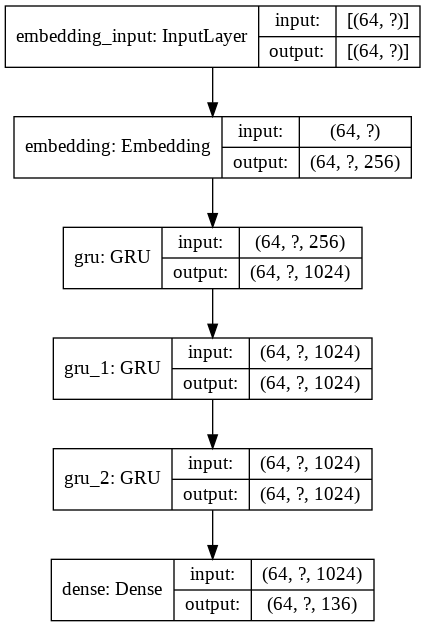

In [29]:
model.summary()
img_path = 'Imagenes'
plot_model(model, to_file=img_path +'mlp-mnist.png', show_shapes=True)

## 5. Configuración de checkpoints

Creamos un directorio *training_checkpoints* y utilizamos *tf.keras.callbacks.ModelCheckpoint* para guardar los puntos de control (los pesos) durante el entrenamiento.


In [30]:
#directorio donde los checkpoints(puntos de control) serán guardados
checkpoint_dir = './training_checkpoints'
#nombre de los puntos de control(checkpoint files)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix, #direccion o ruta
    save_weights_only=True) #se guardan solo los pesos

## 6. Entrenamiento

El lote de datos pasa por el modelo y devuelve un tensor de tamaño (64, 100, 65). Como el vocabulario tien 65 caracteres y cada sequencia tiene tamaño 100, el modelo predice el siguiente caracter para cada caracter en la entrada, luego el modelo asigna un valor numérico a cada elemento en el vocabulario. Cómo se elige? Se puede elegir el valor numerico máximo o se puede elegir atoriamente, que resulta ser mejor que tomar el maximo.

Para elegir aleatoriamente o tomar la muestra, la distribución es calculada a partir de las predicciones(logits) que son generadas para cada caracter del vocabulario. Para cada lote de 64 secuencias la función de pérdida se obtiene con el promedio de 64∗100=6400 entropías cruzadas dispersas.

Para compilar el modelo utilizamos la función de pérdida de entropía cruzada y el optimizardor Adam.

In [31]:
model.compile(optimizer='adam',loss=loss)

In [32]:
#en history queda registrado la funcion de perdida y la precision para el modelo, tanto en entrenamiento como en test
EPOCHS=10
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
1513/1513 [==============================] - 208s 137ms/step - loss: 1.6758
Epoch 2/10
1513/1513 [==============================] - 207s 137ms/step - loss: 1.3312
Epoch 3/10
1513/1513 [==============================] - 207s 137ms/step - loss: 1.2950
Epoch 4/10
1513/1513 [==============================] - 207s 137ms/step - loss: 1.2812
Epoch 5/10
1513/1513 [==============================] - 207s 137ms/step - loss: 1.2756
Epoch 6/10
1513/1513 [==============================] - 207s 137ms/step - loss: 1.2754
Epoch 7/10
1513/1513 [==============================] - 207s 137ms/step - loss: 1.2772
Epoch 8/10
1513/1513 [==============================] - 206s 136ms/step - loss: 1.2809
Epoch 9/10
1513/1513 [==============================] - 206s 136ms/step - loss: 1.2866
Epoch 10/10
1513/1513 [==============================] - 206s 136ms/step - loss: 1.2939


## 7. Generación de texto

### Restauración del último  checkpoint

Debido a la forma en que se pasa el estado RNN de un paso a otro, el modelo solo acepta un tamaño de lote fijo una vez construido, asi que tomaremos el pre-entranamiento usando los pesos almacenados y un tamaño de lote de 1. Si se quisiera ejecutar el modelo con un tamaño de lote diferente, se necesitaría reconstruir el modelo y restaurar los pesos desde el punto de control.

In [33]:
#tomamos un solo batch
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

#utilizamos los checkpoint del pre-entrenamiento
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

#reconstruimos el modelo
model.build(tf.TensorShape([1, None]))

### Predicción

¿Cómo se genera el texto?:

* Se introduce una cadena de inicio, se inicializa el estado de la  RNN y se configura el número de caracteres a generar.

* Se obtiene la distribución de predicción del siguiente carácter utilizando la cadena de inicio y el estado de la  RNN y se calcula el índice del carácter predicho. 

* Se usa este caracter predicho como la próxima entrada al modelo.

* El estado RNN devuelto retroalimenta al modelo para que ahora tenga más contexto, en lugar de una sola palabra. Después de predecir la siguiente palabra, los estados RNN modificados se retroalimentan nuevamente en el modelo, que es cómo aprende a medida que obtiene más contexto de las palabras predichas previamente.

Vamos a hacer la función para generar texto basada en los pesos obtenidos en el modelo pre-entrenado, aquí utilizamos un nuevo concepto *la temperatura* que indica que tan sorprendente o aleatorio puede ser un resultado, toma valores entre 0 y 1, donde un valor cercano a 0 indica que es mas predecible y un valor cercano a 1 indica que el resultado es más aleatorio.

In [34]:
#funcion para generar texto usando el modelo pre-entrenado
def generate_text(model, start_string, num_generate):

  #convertimos el texto inicial en numeros (vectorizacion)
  input_eval = [charxid[s] for s in start_string] #vector columna
  input_eval = tf.expand_dims(input_eval, 0) #vector fila, agrega una diension

  #guardamos el texto predicho
  text_generated = []

  temperature = 1.0

  #tamaño del bache== 1
  model.reset_states() #reinia o borra el estado recurrente de la red. Dejando valores aleatorios o ceros.
  for i in range(num_generate):
      predictions = model(input_eval)
      #removemos la dimensión del batch, quita una dimensión
      predictions = tf.squeeze(predictions, 0)

      #usamos la distribución categorica para predecir la palabra que retorna el modelo
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      #utilizamos la palabra predicha y el estado oculto anterior como entrada
      input_eval = tf.expand_dims([predicted_id], 0) #devuelve un tensor con una dimensión adicional en el eje de índice

      text_generated.append(idxchar[predicted_id])

  return (start_string + ''.join(text_generated))

Notemos que el texto generado es capaz de utilizar mayusculas, minusculas y signos de puntuación para construir frases con el vocabulario de los Simpons.

In [35]:
print(generate_text(model, start_string=u"Homer Simpson: ", num_generate=500))

Homer Simpson: Was you're doing it!
C. Montgomery Burns: (STIFFLES) You know, I sseired by the coalboas.
Captain Horatio McCluencer: I can do in!
Ralph Wiggum: Ooh!
Homer Simpson: (CHMISSED ON THE, TO ITCRELE) That's what we're not usually never gone, Flanders, wonderscy and love the film, and yeah, oh, that's where I think of love in us!
Chief Wiggum: (INTO WAiLE) (GASPS) I guess we're gonna believe a good full for Coltersyl!
Milhouse Van Houten: I'm mash on a great figure. He's ready us no own Assistans! (GE


## Avanzado: Entrenamiento personalizado

Para mejorar el entrenamiento anterior y obtener más control usaremos `tf.GradientTape` bajo los siguientes pasos:

* Utilizamos el mismo modelo y el optimizador adam.

* Inicializamos el estado RNN llamando al método `tf.keras.Model.reset_states`.

* Repetimos el conjunto de datos (lote por lote) y calculamos las predicciones asociadas con cada una.

* Abrimos un `tf.GradientTape`, y calculamos las predicciones y pérdidas en ese contexto.

* Calculamos los gradientes de la pérdida con respecto a las variables del modelo utilizando el método `tf.GradientTape.grads`.

* Finalmente, damos un paso hacia abajo utilizando el método `tf.train.Optimizer.apply_gradients` del optimizador.

In [36]:
#modelo
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [37]:
#optimizador
optimizer = tf.keras.optimizers.Adam()

In [38]:
@tf.function
def train_step(inp, target): 
  with tf.GradientTape() as tape:
    predictions = model(inp)
    loss = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(
            target, predictions, from_logits=True))
  grads = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))

  return loss

Con lo anterior hacemos el pre-entrenamiento.

In [39]:
EPOCHS = 10

for epoch in range(EPOCHS):
  start = time.time()

  #inicializamos el estado oculto al comienzo de cada época
  hidden = model.reset_states()

  for (batch_n, (inp, target)) in enumerate(dataset):
    loss = train_step(inp, target) #usamos la funcion train_step que acabamos de creamr

    if batch_n % 100 == 0:
      template = 'Epoch {} Batch {} Loss {}'
      print(template.format(epoch+1, batch_n, loss))

  #guardamos los 'checkpoint' del modelo cada 5 epocas
  if (epoch + 1) % 5 == 0:
    model.save_weights(checkpoint_prefix.format(epoch=epoch))

  print ('Epoch {} Loss {:.4f}'.format(epoch+1, loss))
  print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

#imprimimos la perida y los pesos guardados
model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 4.913026332855225
Epoch 1 Batch 100 Loss 2.317227840423584
Epoch 1 Batch 200 Loss 1.9274165630340576
Epoch 1 Batch 300 Loss 1.747829556465149
Epoch 1 Batch 400 Loss 1.5455212593078613
Epoch 1 Batch 500 Loss 1.5282138586044312
Epoch 1 Batch 600 Loss 1.4177162647247314
Epoch 1 Batch 700 Loss 1.3713375329971313
Epoch 1 Batch 800 Loss 1.3693203926086426
Epoch 1 Batch 900 Loss 1.3560467958450317
Epoch 1 Batch 1000 Loss 1.3411974906921387
Epoch 1 Batch 1100 Loss 1.3046380281448364
Epoch 1 Batch 1200 Loss 1.287421703338623
Epoch 1 Batch 1300 Loss 1.204250454902649
Epoch 1 Batch 1400 Loss 1.2329068183898926
Epoch 1 Batch 1500 Loss 1.2926632165908813
Epoch 1 Loss 1.2791
Time taken for 1 epoch 208.29581356048584 sec

Epoch 2 Batch 0 Loss 1.2105298042297363
Epoch 2 Batch 100 Loss 1.2507838010787964
Epoch 2 Batch 200 Loss 1.2658448219299316
Epoch 2 Batch 300 Loss 1.2017096281051636
Epoch 2 Batch 400 Loss 1.1777077913284302
Epoch 2 Batch 500 Loss 1.180179476737976
Epoch 2 Batch

Ahora, vamos a utilizar el modelo pre-entrenado, pero vamos a utilizar un solo bache.

In [40]:
#tomamos un solo batch
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

#utilizamos los checkpoint del pre-entrenamiento
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

#reconstruimos el modelo
model.build(tf.TensorShape([1, None]))

Y utilizamos nuevamente la funcion generadora de texto.

In [41]:
#funcion para generar texto usando el modelo pre-entrenado
def generate_text(model, start_string, num_generate):

  #convertimos el texto inicial en numeros (vectorizacion)
  input_eval = [charxid[s] for s in start_string] #vector columna
  input_eval = tf.expand_dims(input_eval, 0) #vector fila, agrega una diension

  #guardamos el texto predicho
  text_generated = []

  temperature = 1.0

  #tamaño del bache== 1
  model.reset_states() #reinia o borra el estado recurrente de la red. Dejando valores aleatorios o ceros.
  for i in range(num_generate):
      predictions = model(input_eval)
      #removemos la dimensión del batch, quita una dimensión
      predictions = tf.squeeze(predictions, 0)

      #usamos la distribución categorica para predecir la palabra que retorna el modelo
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      #utilizamos la palabra predicha y el estado oculto anterior como entrada
      input_eval = tf.expand_dims([predicted_id], 0) #devuelve un tensor con una dimensión adicional en el eje de índice

      text_generated.append(idxchar[predicted_id])

  return (start_string + ''.join(text_generated))

Podemos ver que este código nos da resultados mas coherentes.

## Conectar Redes: Clasificaror con Generador

In [71]:
pr="Homer: Wherever injustice shows its ugly face, I will be there, for I am the Pie Man."

In [73]:
output_model = generate_text(model,pr, 1000)

In [78]:
def output_ultimate(line):
  if line.split('\n')[1] == ' ':
    line2=line.split('\n')[2]
    labelsLine2 = line2[:line2.index(':')+1]
    line_ultimate = line2.replace(labelsLine2,"")
    print(line_ultimate)
  else:
    line2=line.split('\n')[1]
    labelsLine2 = line2[:line2.index(':')+1]
    line_ultimate = line2.replace(labelsLine2,"")
    print(line_ultimate)

In [79]:
output_ultimate(output_model)

 (VERY ANNOYED) go to the scorecroo-man, lose. (TO SEGUNEADS) Caleball!


In [80]:
## 12. Referencias

#- Aprendizaje profundo, [Repositorio Ciencia-de-datos](https://github.com/AprendizajeProfundo/Ciencia-de-Datos)
#- Tensorflow, [Generación de texto con una red neuronal recurrente (RNN)](https://www.tensorflow.org/tutorials/text/text_generation)
#- Google, [Machine learning crash course](https://developers.google.com/machine-learning/crash-course/embeddings/video-lecture)